In [2]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import os
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import glob
import random

In [4]:
path = kagglehub.dataset_download("acharyarupak391/vggfaceweights")
weights_path = f"{path}/vgg_face_weights.h5"
print("Path to VGGFace weights file:", weights_path)

100%|██████████| 521M/521M [00:12<00:00, 42.0MB/s]

Extracting files...


Path to VGGFace weights file: /root/.cache/kagglehub/datasets/acharyarupak391/vggfaceweights/versions/1/vgg_face_weights.h5


In [5]:
# download LFW dataset
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz

--2024-11-17 04:25:47--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  2.07MB/s    in 2m 8s   

2024-11-17 04:27:56 (1.34 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [6]:
def cosine_similarity(emb1, emb2):
    emb1 = emb1.reshape(-1)
    emb2 = emb2.reshape(-1)
    dot = np.dot(emb1, emb2)
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)
    return dot / (norm1 * norm2)

This model was built based on a tutorial from Vimai Pillai's Facial Recognition using VGGFace Keras notebook on Kaggle, which can be found here https://www.kaggle.com/code/vimalpillai/facial-recognition-using-vggface-keras.

In [7]:
def build_vggface_model():
    model = Sequential()
    model.add(ZeroPadding2D((1,1), input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))

    return model

In [8]:
def preprocess_image_basic(image_path):
    # basic preprocessing without MTCNN
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

In [9]:
def process_mtcnn(image_path, required_size=(224, 224)):
    # load images and detect faces
    pixels = plt.imread(image_path)
    detector = MTCNN()
    results = detector.detect_faces(pixels)

    if not results:
        raise ValueError("No face detected")

    # extract face coordinates
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height

    # extract and resize face
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    face_array = np.expand_dims(face_array, axis=0)

    return face_array

In [10]:
def visualize_detection(image_path, with_landmarks=True):
    detector = MTCNN()
    img = Image.open(image_path)
    img = img.convert('RGB')
    img_array = np.array(img)
    faces = detector.detect_faces(img_array)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_array)

    if faces:
        face = faces[0]
        x, y, width, height = face['box']
        plt.gca().add_patch(plt.Rectangle((x, y), width, height,
                                        fill=False, color='red', linewidth=2))
        if with_landmarks:
            landmarks = face['keypoints']
            for point in landmarks.values():
                plt.plot(point[0], point[1], 'go', markersize=10)
    else:
        plt.title("No face")
    plt.axis('off')
    plt.show()

Face detections:


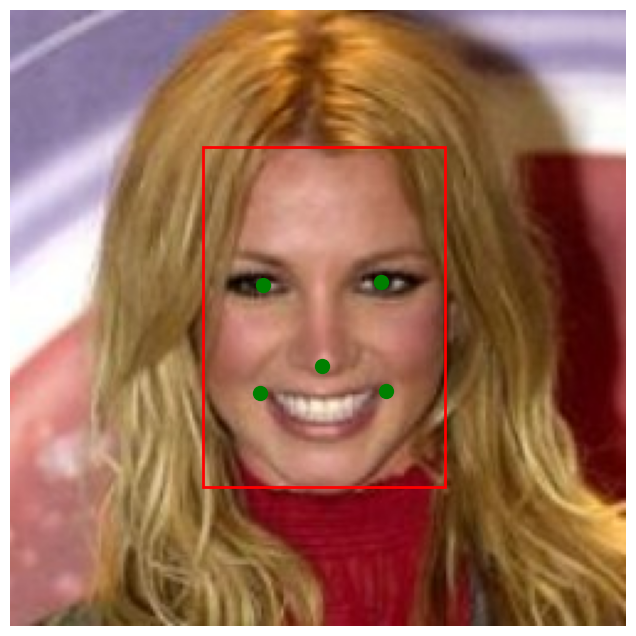

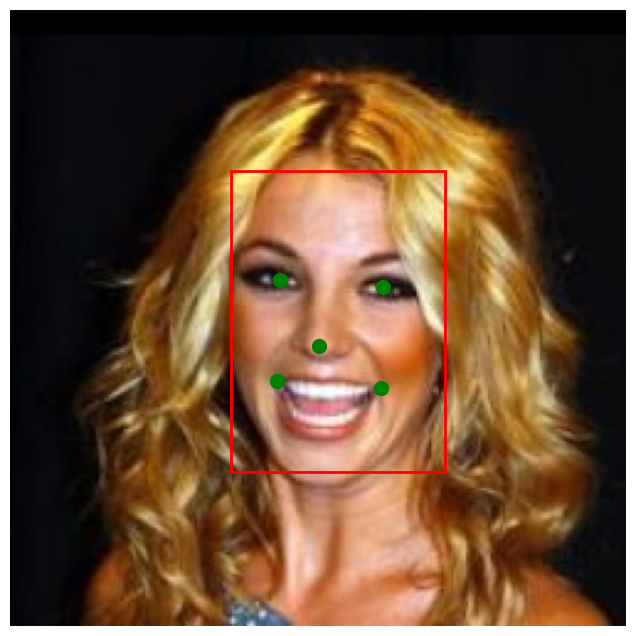

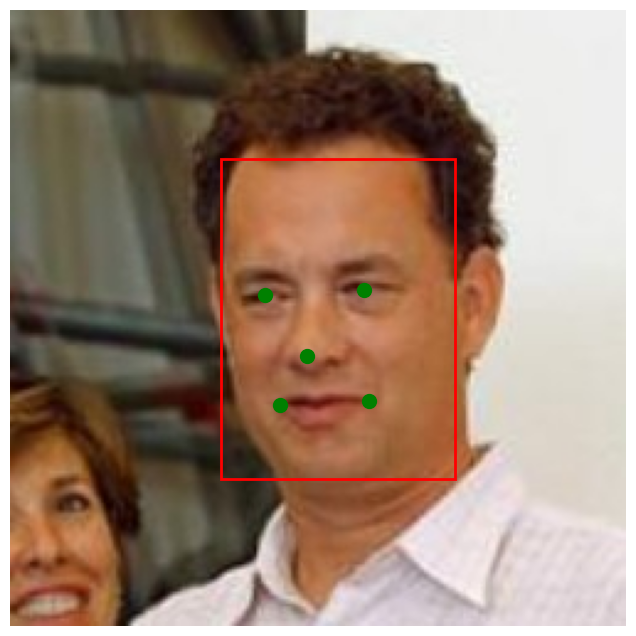

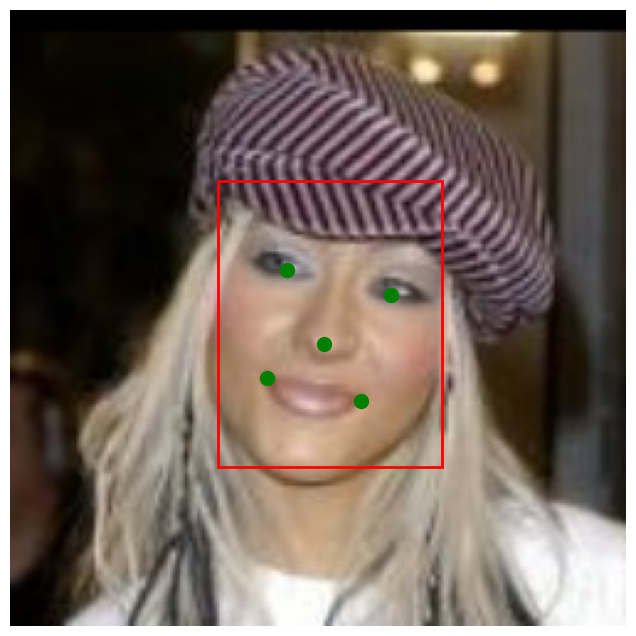

In [11]:
print("Face detections:")
visualize_detection('lfw/Britney_Spears/Britney_Spears_0001.jpg')
visualize_detection('lfw/Britney_Spears/Britney_Spears_0005.jpg')

visualize_detection('lfw/Tom_Hanks/Tom_Hanks_0001.jpg')
visualize_detection('lfw/Christina_Aguilera/Christina_Aguilera_0001.jpg')


We will pick 500 pairs of same people and 500 pairs of different people to test our model.

In [12]:
def process_lfw_pairs(lfw_dir="lfw", num_same=500, num_different=500):
    person_dirs = [d for d in os.listdir(lfw_dir) if os.path.isdir(os.path.join(lfw_dir, d))]
    pairs = []

    same_person_count = 0
    while same_person_count < num_same:
        person = random.choice(person_dirs)
        person_path = os.path.join(lfw_dir, person)
        images = os.listdir(person_path)

        if len(images) >= 2:
            img1, img2 = random.sample(images, 2)
            pairs.append((os.path.join(person_path, img1), os.path.join(person_path, img2), 1))
            same_person_count += 1

    different_person_count = 0
    while different_person_count < num_different:
        person1, person2 = random.sample(person_dirs, 2)
        person1_path = os.path.join(lfw_dir, person1)
        person2_path = os.path.join(lfw_dir, person2)

        img1 = random.choice(os.listdir(person1_path))
        img2 = random.choice(os.listdir(person2_path))

        pairs.append((os.path.join(person1_path, img1), os.path.join(person2_path, img2), 0))
        different_person_count += 1

    return pairs


In [13]:
def show_pair_predictions(model, img1_path, img2_path, label, threshold=0.4):

    # get faces
    face1 = process_mtcnn(img1_path)
    face2 = process_mtcnn(img2_path)

    # get embeddings and similarity
    emb1 = model.predict(face1, verbose=0)
    emb2 = model.predict(face2, verbose=0)
    similarity = cosine_similarity(emb1, emb2)
    prediction = "Same Person" if similarity > threshold else "Different Person"

    plt.figure(figsize=(12, 6))

    # original images
    plt.subplot(2, 2, 1)
    plt.imshow(plt.imread(img1_path))
    plt.title("Original Image 1")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(plt.imread(img2_path))
    plt.title("Original Image 2")
    plt.axis('off')

    # MTCNN processed faces
    plt.subplot(2, 2, 3)
    plt.imshow(face1[0])
    plt.title("MTCNN Processed Face 1")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(face2[0])
    plt.title("MTCNN Processed Face 2")
    plt.axis('off')

    plt.suptitle(f'Real: {"Same" if label==1 else "Different"} Person\n' +
                 f'Prediction: {prediction}\nCosine Similarity: {similarity:.4f}',
                 y=1.05)
    plt.tight_layout()
    plt.show()


In [14]:
model = build_vggface_model()
model.load_weights(weights_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# process pairs
pairs = process_lfw_pairs(num_same=50, num_different=50)

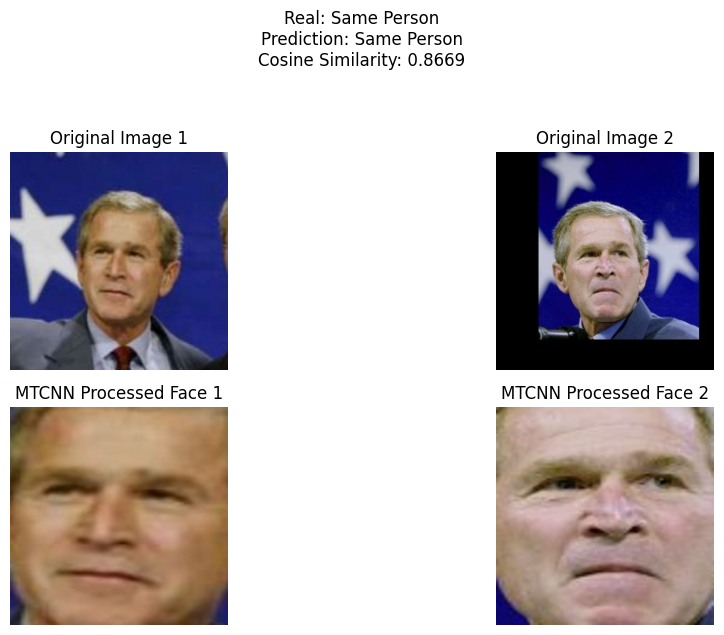

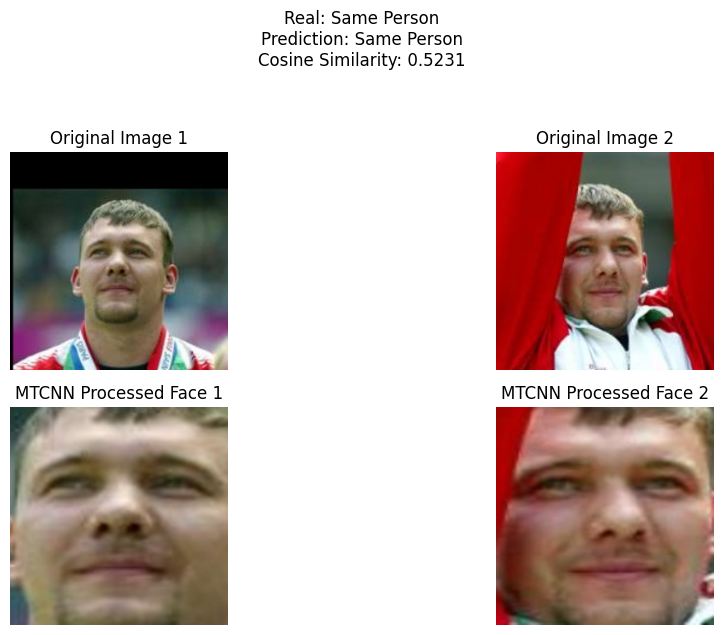

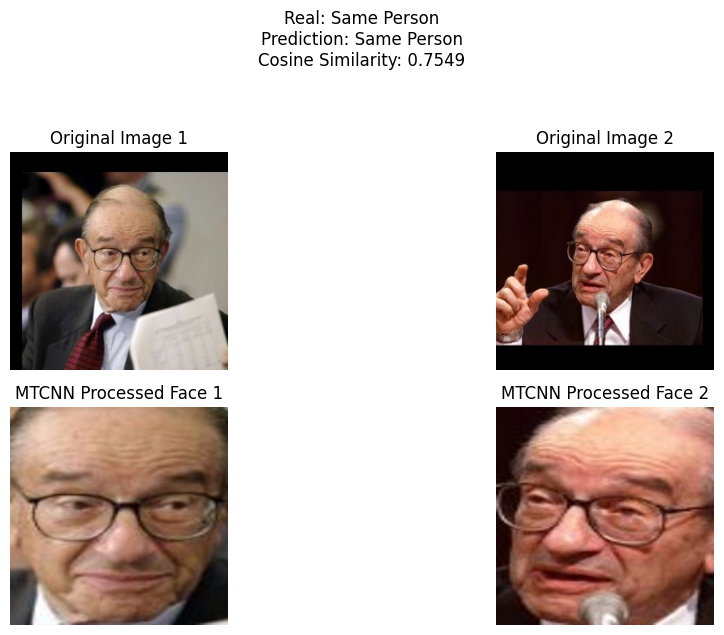

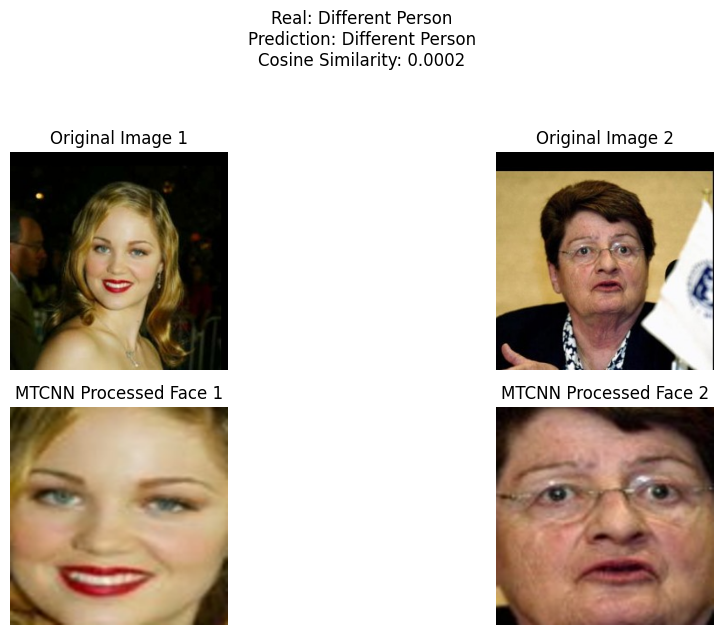

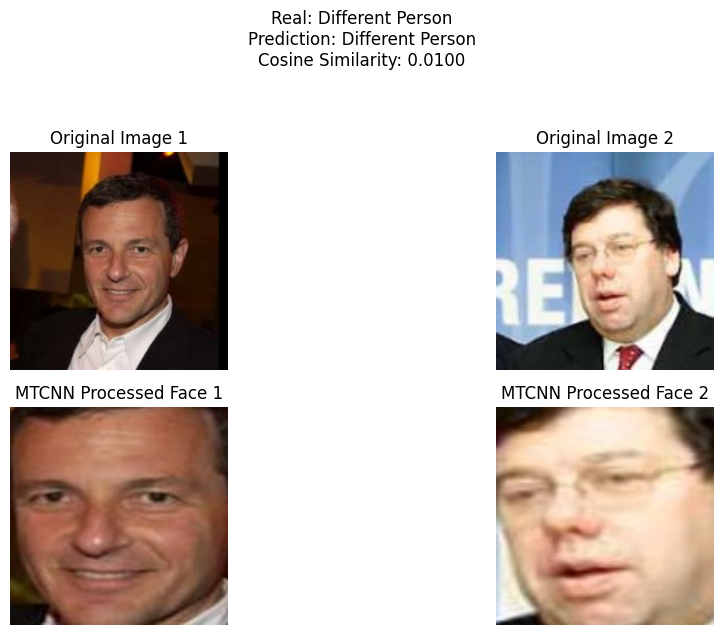

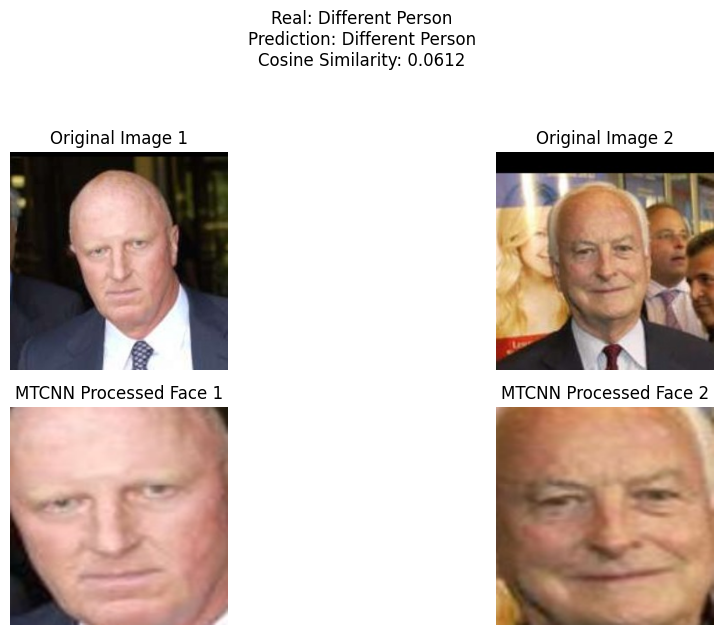

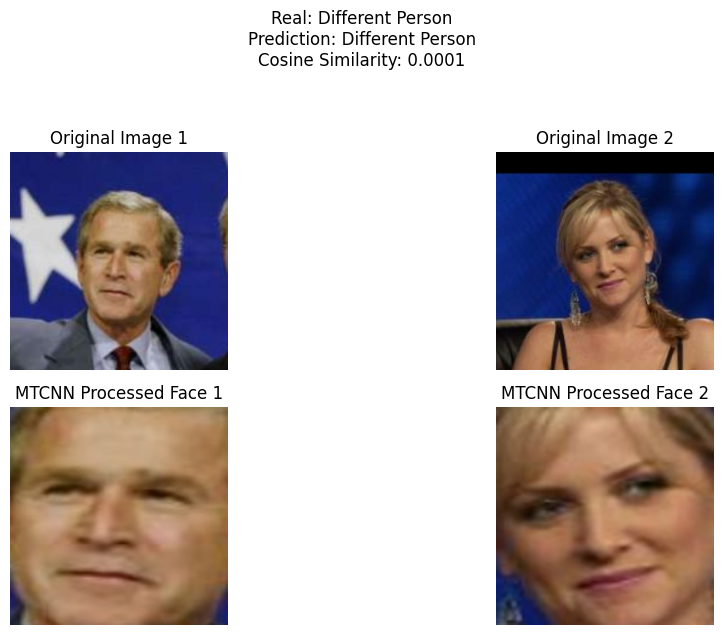

In [16]:
show_pair_predictions(model, "lfw/George_W_Bush/George_W_Bush_0001.jpg", "lfw/George_W_Bush/George_W_Bush_0002.jpg", label=1)
show_pair_predictions(model, "lfw/Andrei_Mikhnevich/Andrei_Mikhnevich_0001.jpg", "lfw/Andrei_Mikhnevich/Andrei_Mikhnevich_0002.jpg", label=1)
show_pair_predictions(model, "lfw/Alan_Greenspan/Alan_Greenspan_0001.jpg", "lfw/Alan_Greenspan/Alan_Greenspan_0005.jpg", label=1)
show_pair_predictions(model, "lfw/Erika_Christensen/Erika_Christensen_0001.jpg", "lfw/Anne_Krueger/Anne_Krueger_0001.jpg", label=0)
show_pair_predictions(model, "lfw/Bob_Iger/Bob_Iger_0001.jpg", "lfw/Brian_Cowen/Brian_Cowen_0001.jpg", label=0)
show_pair_predictions(model, "lfw/Dennis_Kozlowski/Dennis_Kozlowski_0002.jpg", "lfw/James_Ivory/James_Ivory_0001.jpg", label=0)
show_pair_predictions(model, "lfw/George_W_Bush/George_W_Bush_0001.jpg", "lfw/Jessica_Capshaw/Jessica_Capshaw_0001.jpg", label=0)

In [17]:
def evaluate_model(model, pairs, use_mtcnn=True):

    similarities = []
    labels = []
    failed = 0

    print(f"Evaluating {'with' if use_mtcnn else 'without'} MTCNN")
    for img1_path, img2_path, label in pairs:
        # Process images
        if use_mtcnn:
            face1 = process_mtcnn(img1_path)
            face2 = process_mtcnn(img2_path)
        else:
            face1 = preprocess_image_basic(img1_path)
            face2 = preprocess_image_basic(img2_path)

        # Get predictions
        emb1 = model.predict(face1, verbose=0)
        emb2 = model.predict(face2, verbose=0)
        similarity = cosine_similarity(emb1, emb2)[0][0]

        similarities.append(similarity)
        labels.append(label)

    predictions = (np.array(similarities) >= 0.5).astype(int)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
    }

In [18]:
def compare(model, lfw_dir, num_pairs=500):

    pairs = process_lfw_pairs(lfw_dir, num_pairs//2, num_pairs//2)

    mtcnn_results = evaluate_model(model, pairs, use_mtcnn=True)
    basic_results = evaluate_model(model, pairs, use_mtcnn=False)

    print("\nResults:")
    print(f"{'Metric'} | {'With MTCNN'} | {'Without MTCNN'}")
    print("-" * 35)
    for metric in ['accuracy', 'precision', 'recall']:
        print(f"{metric} | {mtcnn_results[metric]:.3f}      | {basic_results[metric]:.3f}")


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_model_minimal(model, pairs, use_mtcnn=True):
    """Simple evaluation returning accuracy, precision, recall, and F1"""
    similarities = []
    labels = []

    print(f"Evaluating {'with' if use_mtcnn else 'without'} MTCNN")
    for img1_path, img2_path, label in pairs:
        # process images
        if use_mtcnn:
            face1 = process_mtcnn(img1_path)
            face2 = process_mtcnn(img2_path)
        else:
            face1 = preprocess_image_basic(img1_path)
            face2 = preprocess_image_basic(img2_path)

        # get predictions
        emb1 = model.predict(face1, verbose=0)
        emb2 = model.predict(face2, verbose=0)
        # reshape embeddings to 2D arrays for cosine_similarity
        similarity = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]

        similarities.append(similarity)
        labels.append(label)

    predictions = (np.array(similarities) >= 0.5).astype(int)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions)
    }

In [20]:
def compare(model, lfw_dir, num_pairs=500):

    pairs = process_lfw_pairs(lfw_dir, num_pairs//2, num_pairs//2)

    mtcnn_results = evaluate_model_minimal(model, pairs, use_mtcnn=True)
    basic_results = evaluate_model_minimal(model, pairs, use_mtcnn=False)

    print("\nResults:")
    print(f"{'Metric':<10} | {'With MTCNN':<10} | {'Without MTCNN':<10}")
    print("-" * 35)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"{metric:<10} | {mtcnn_results[metric]:.3f}      | {basic_results[metric]:.3f}")

In [ ]:
compare(model, "lfw", num_pairs=1000)